# Build Datasets
Due to the limitation of dataset size, here i will create a new similar dataset from public dataset that can be found in [bhanupratapbiswas/fashion-products](https://www.kaggle.com/datasets/bhanupratapbiswas/fashion-products).

# Import Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Re-factor Datasets

## Load Original Data

In [26]:
df_data = pd.read_csv(f'../datasets/fashion/fashion_products.csv')
print(df_data.shape)
df_data.head()

(1000, 9)


,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


In [27]:
print('Total Product:', len(df_data['Product Name'].unique()))
print('Total Brand:', len(df_data['Brand'].unique()))
print('Total Category:', len(df_data['Category'].unique()))

Total Product: 5
Total Brand: 5
Total Category: 3


## Simplify Product Catalog
Due to the large variety of products, we will simplify the product catalog that ignore the color and size. We will assume the price is the same as the average of any color and size.

In [28]:
df_catalog = df_data.drop(columns=['User ID', 'Product ID', 'Rating']).drop_duplicates()
df_catalog = df_catalog.groupby(by=['Product Name', 'Brand', 'Category']).agg({'Price': 'mean'}).reset_index()
df_catalog

,Product Name,Brand,Category,Price
0,Dress,Adidas,Kids' Fashion,53.916667
1,Dress,Adidas,Men's Fashion,44.500000
2,Dress,Adidas,Women's Fashion,47.666667
3,Dress,Gucci,Kids' Fashion,50.200000
4,Dress,Gucci,Men's Fashion,51.125000
...,...,...,...,...
70,T-shirt,Nike,Men's Fashion,56.500000
71,T-shirt,Nike,Women's Fashion,72.166667
72,T-shirt,Zara,Kids' Fashion,65.750000
73,T-shirt,Zara,Men's Fashion,52.818182


## Assing Product ID
We will assign new product ID according to this number of product variations

In [29]:
df_catalog = df_catalog.reset_index(names=['Product ID'])
df_catalog

,Product ID,Product Name,Brand,Category,Price
0,0,Dress,Adidas,Kids' Fashion,53.916667
1,1,Dress,Adidas,Men's Fashion,44.500000
2,2,Dress,Adidas,Women's Fashion,47.666667
3,3,Dress,Gucci,Kids' Fashion,50.200000
4,4,Dress,Gucci,Men's Fashion,51.125000
...,...,...,...,...,...
70,70,T-shirt,Nike,Men's Fashion,56.500000
71,71,T-shirt,Nike,Women's Fashion,72.166667
72,72,T-shirt,Zara,Kids' Fashion,65.750000
73,73,T-shirt,Zara,Men's Fashion,52.818182


## Build Dataset
This will be our dataset and will be normalize as the same as the given one

In [30]:
df_dataset = pd.merge(
    left=df_data[['User ID', 'Product Name', 'Brand', 'Category', 'Rating']],
    right=df_catalog,
    on=['Product Name', 'Brand', 'Category'],
)
df_dataset

,User ID,Product Name,Brand,Category,Rating,Product ID,Price
0,19,Dress,Adidas,Men's Fashion,1.043159,1,44.500000
1,97,Shoes,H&M,Women's Fashion,4.026416,38,69.636364
2,25,Dress,Adidas,Women's Fashion,3.337938,2,47.666667
3,57,Shoes,Zara,Men's Fashion,1.049523,43,55.388889
4,79,T-shirt,Adidas,Men's Fashion,4.302773,61,58.294118
...,...,...,...,...,...,...,...
995,20,Shoes,Zara,Women's Fashion,1.620081,44,49.466667
996,42,Sweater,Nike,Kids' Fashion,1.544464,54,49.100000
997,9,Sweater,Zara,Men's Fashion,3.961913,58,48.250000
998,8,T-shirt,Zara,Women's Fashion,3.089722,74,67.375000


# Interaction Dataset
Because this public dataset does not have the number of `page_view` and `time_spent`, so we will generate the values based on given characteristics

## Original Dataset Statistic

In [31]:
df_interaction = pd.read_csv('../datasets/original/customer_interactions.csv')
df_interaction

,customer_id,page_views,time_spent
0,1,25,120
1,2,20,90
2,3,30,150
3,4,15,80
4,5,22,110


In [32]:
df_history = pd.read_csv('../datasets/original/purchase_history.csv', sep=';')
df_history = df_history.loc[:, ~df_history.columns.str.contains('^Unnamed')]
df_history

,customer_id,product_id,purchase_date
0,1,101,2023-01-01
1,1,105,2023-01-05
2,2,102,2023-01-02
3,3,103,2023-01-03
4,4,104,2023-01-04
5,5,101,2023-01-05


In [33]:
df_user_purchase = df_history.groupby(by=['customer_id']).agg({'product_id': 'count'}).reset_index().rename(columns={'product_id': 'purchased_items'})

df_stat = pd.merge(
    left=df_interaction,
    right=df_user_purchase,
    on=['customer_id'],
)
df_stat

,customer_id,page_views,time_spent,purchased_items
0,1,25,120,2
1,2,20,90,1
2,3,30,150,1
3,4,15,80,1
4,5,22,110,1


In [34]:
df_stat['views_per_purchase'] = df_stat['page_views'] / df_stat['purchased_items']
df_stat['views_per_purchase'].describe()

count     5.00000
mean     19.90000
std       6.80441
min      12.50000
25%      15.00000
50%      20.00000
75%      22.00000
max      30.00000
Name: views_per_purchase, dtype: float64

In [35]:
df_stat['time_per_purchase'] = df_stat['time_spent'] / df_stat['purchased_items']
df_stat['time_per_purchase'].describe()

count      5.000000
mean      98.000000
std       34.205263
min       60.000000
25%       80.000000
50%       90.000000
75%      110.000000
max      150.000000
Name: time_per_purchase, dtype: float64

## Build Synthetic Dataset

In [36]:
df_interaction = df_dataset.groupby(
    by=['User ID']
).agg({'Product ID': 'count'}).reset_index().rename(columns={
    'User ID': 'customer_id',
    'Product ID': 'purchased_items',
})
df_interaction

,customer_id,purchased_items
0,1,9
1,2,9
2,3,11
3,4,12
4,5,8
...,...,...
95,96,6
96,97,9
97,98,14
98,99,8


In [37]:
def clip_value(val, val_min, val_max):
    return max(val_min, val)
    # return max(val_min, min(val_max, val))

def synthetic_value(n, mean_std_min_max, clip=False):
    mean, std, min_, max_ = mean_std_min_max
    val = n * np.random.normal(mean, std)
    if clip:
        val = clip_value(val, min_, max_)
    return int(val)


df_interaction['page_views'] = df_interaction['purchased_items'].apply(
    lambda n: synthetic_value(n, df_stat['views_per_purchase'].agg(['mean', 'std', 'min', 'max']).values, clip=True)
)
df_interaction['time_spent'] = df_interaction['purchased_items'].apply(
    lambda n: synthetic_value(n, df_stat['time_per_purchase'].agg(['mean', 'std', 'min', 'max']).values, clip=True)
)
df_interaction.drop(columns=['purchased_items']).to_csv('../datasets/fashion/customer_interactions.csv', index=False)
df_interaction

,customer_id,purchased_items,page_views,time_spent
0,1,9,175,1121
1,2,9,271,1337
2,3,11,348,1218
3,4,12,251,1199
4,5,8,175,999
...,...,...,...,...
95,96,6,162,629
96,97,9,147,738
97,98,14,205,474
98,99,8,186,929


## Synthetic Dataset Statistic

In [38]:
df_stat2 = df_interaction.copy()
df_stat2['views_per_purchase'] = df_stat2['page_views'] / df_stat2['purchased_items']
df_stat2['views_per_purchase'].describe()

count    100.000000
mean      19.917004
std        7.301235
min        2.357143
25%       14.471154
50%       19.991071
75%       24.746528
max       37.333333
Name: views_per_purchase, dtype: float64

In [39]:
df_stat2['time_per_purchase'] = df_stat2['time_spent'] / df_stat2['purchased_items']
df_stat2['time_per_purchase'].describe()

count    100.000000
mean     101.743904
std       31.129341
min       32.142857
25%       80.322222
50%      100.619231
75%      119.625000
max      172.500000
Name: time_per_purchase, dtype: float64

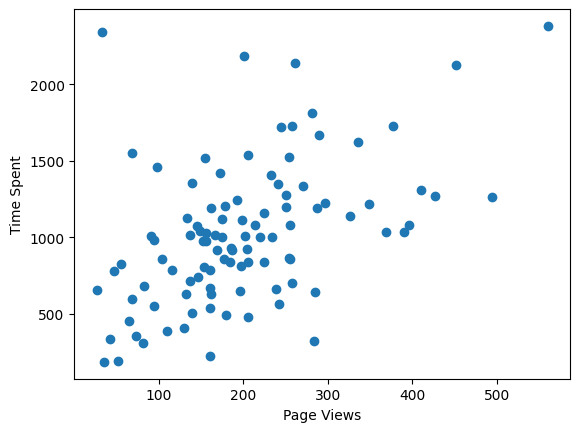

In [40]:
plt.scatter(df_interaction['page_views'], df_interaction['time_spent'])
plt.xlabel('Page Views')
plt.ylabel('Time Spent')
plt.show()

# Product Details

In [41]:
df_dataset.head()

,User ID,Product Name,Brand,Category,Rating,Product ID,Price
0,19,Dress,Adidas,Men's Fashion,1.043159,1,44.500000
1,97,Shoes,H&M,Women's Fashion,4.026416,38,69.636364
2,25,Dress,Adidas,Women's Fashion,3.337938,2,47.666667
3,57,Shoes,Zara,Men's Fashion,1.049523,43,55.388889
4,79,T-shirt,Adidas,Men's Fashion,4.302773,61,58.294118


In [42]:
df_product = df_dataset.groupby(
    by=['Product Name', 'Brand', 'Category', 'Product ID']
).agg({
    'Rating': 'mean', 
    'Price': 'mean'
}).reset_index()
df_product = df_product.rename(columns={
    'Product ID': 'product_id',
})
df_product = df_product.rename(columns={
    'Product Name': 'category',
    'Rating': 'ratings',
    'Price': 'price',
    'Brand': 'brand',
    'Category': 'kind',
})
df_product.sort_values(by=['product_id'])
df_product = df_product[['product_id', 'ratings', 'price', 'category', 'brand', 'kind']]
df_product.to_csv('../datasets/fashion/product_details.csv', sep=';', index=False)
df_product

,product_id,ratings,price,category,brand,kind
0,0,3.270463,53.916667,Dress,Adidas,Kids' Fashion
1,1,2.879264,44.500000,Dress,Adidas,Men's Fashion
2,2,2.673620,47.666667,Dress,Adidas,Women's Fashion
3,3,3.689981,50.200000,Dress,Gucci,Kids' Fashion
4,4,3.282323,51.125000,Dress,Gucci,Men's Fashion
...,...,...,...,...,...,...
70,70,2.436425,56.500000,T-shirt,Nike,Men's Fashion
71,71,2.636504,72.166667,T-shirt,Nike,Women's Fashion
72,72,3.548573,65.750000,T-shirt,Zara,Kids' Fashion
73,73,2.520955,52.818182,T-shirt,Zara,Men's Fashion


# Purchase History

In [43]:
df_history = df_dataset[['User ID', 'Product ID']].rename(columns={'User ID': 'customer_id', 'Product ID': 'product_id'})
df_history['purchase_date'] = None
df_history.to_csv('../datasets/fashion/purchase_history.csv', sep=';', index=False)
df_history

,customer_id,product_id,purchase_date
0,19,1,None
1,97,38,None
2,25,2,None
3,57,43,None
4,79,61,None
...,...,...,...
995,20,44,None
996,42,54,None
997,9,58,None
998,8,74,None


# Graph Database

In [49]:
from d3graph import d3graph, vec2adjmat

In [58]:
df_purchase = pd.merge(
    df_product,
    df_history,
    on=['product_id'],
)

# Brand level
df_purchase['category'] = df_purchase['brand'].astype(str)

# # Category + Brand level
# df_purchase['category'] = df_purchase['category'].astype(str) + '_' + df_purchase['brand'].astype(str)

df_purchase = df_purchase.groupby(by=['customer_id', 'category']).agg(
    {'product_id': 'count'}
).reset_index().rename(columns={'product_id': 'purchased'})
df_purchase


,customer_id,category,purchased
0,1,Gucci,2
1,1,Nike,5
2,1,Zara,2
3,2,Adidas,3
4,2,Gucci,2
...,...,...,...
433,100,Adidas,4
434,100,Gucci,1
435,100,H&M,3
436,100,Nike,3


In [59]:
def build_graph_database(df):
    df['source'] = df['category']
    df['source_total'] = df['purchased']
    df['target'] = df.apply(lambda row: df['category'].values.tolist(), axis=1)
    df['target_total'] = df.apply(lambda row: df['source_total'].values.tolist(), axis=1)
    df = df.explode(column=['target', 'target_total'])
    df['source_target'] = df.apply(lambda row: sorted([row['source'], row['target']]), axis=1)
    df = df.drop_duplicates(subset='source_target')
    df = df[df['source'] != df['target']]
    df['weight'] = df['source_total'] + df['target_total']
    df = df[['source', 'target', 'weight']]
    return df

build_graph_database(df_purchase[df_purchase['customer_id'] == 1])

/var/folders/n2/9hl8ftpn3j379grs52lt_3q80000gn/T/ipykernel_95362/399243268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['source'] = df['category']
/var/folders/n2/9hl8ftpn3j379grs52lt_3q80000gn/T/ipykernel_95362/399243268.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['source_total'] = df['purchased']
/var/folders/n2/9hl8ftpn3j379grs52lt_3q80000gn/T/ipykernel_95362/399243268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,source,target,weight
0,Gucci,Nike,7
0,Gucci,Zara,4
1,Nike,Zara,7


In [60]:
df_graph = df_purchase.groupby(by=['customer_id']).apply(lambda df: build_graph_database(df)).reset_index(drop=True)
df_graph = df_graph.groupby(by=['source', 'target']).agg({'weight': 'sum'}).reset_index()
# df_graph.to_csv('../datasets/fashion/graph-cateogry.csv')
df_graph.to_csv('../datasets/fashion/graph-brand.csv')
# df_graph.to_csv('../datasets/fashion/graph-category-brand.csv')
df_graph

/var/folders/n2/9hl8ftpn3j379grs52lt_3q80000gn/T/ipykernel_95362/4270193050.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_graph = df_purchase.groupby(by=['customer_id']).apply(lambda df: build_graph_database(df)).reset_index(drop=True)


,source,target,weight
0,Adidas,Gucci,323
1,Adidas,H&M,324
2,Adidas,Nike,357
3,Adidas,Zara,347
4,Gucci,H&M,335
5,Gucci,Nike,367
6,Gucci,Zara,343
7,H&M,Nike,360
8,H&M,Zara,360
9,Nike,Zara,388


In [61]:
# Convert to adjacency matrix
adjmat = vec2adjmat(
    df_graph['source'].tolist(), 
    df_graph['target'].tolist(), 
    weight=df_graph['weight'].tolist()
)

# Draw graph database
d3 = d3graph()
d3.graph(adjmat)
# d3.show(filepath='../models/graph/category.html')
d3.show(filepath='../models/graph/brand.html')
# d3.show(filepath='../models/graph/category-brand.html')

[d3graph] INFO> Converting source-target into adjacency matrix..
[d3graph] INFO> Making the matrix symmetric..
[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Converting source-target into adjacency matrix..
[d3graph] INFO> Making the matrix symmetric..
[d3graph] INFO> Converting adjacency matrix into source-target..
[d3graph] INFO> Number of unique nodes: 5
[d3graph] INFO> Slider range is set to [322, 388]
[d3graph] INFO> Write to path: [/Users/syahrul/Personal/ML-Projects/skilvul/technical-test/models/graph/brand.html]
[d3graph] INFO> File already exists and will be overwritten: [/Users/syahrul/Personal/ML-Projects/skilvul/technical-test/models/graph/brand.html]
